# CESM-LE biomass

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
#from collections import OrderedDict
import xarray as xr
import numpy as np
#import dask
#from ncar_jobqueue import NCARCluster
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats
import matplotlib.path as mpath
#style.use('ggplot')

### Get the CESM-LE variables (annual means calculated in cesm-le-annual-means-v2.ipynb)

In [2]:
%%time
path = '/glade/scratch/kristenk/CESM-LE-output/CESM-LE-'
variables = ['diatC_zint','spC_zint','zooC_zint','sigma_surf','IFRAC']

ds_list = []
ds = xr.Dataset()

for v in variables:  
    print(v)
    files = sorted(glob(f'{path}{v}.nc'))  

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)
    
    ds = xr.merge((ds, dsv))
    ds_list.append(ds)

diatC_zint
spC_zint
zooC_zint
sigma_surf
IFRAC
CPU times: user 302 ms, sys: 22.4 ms, total: 324 ms
Wall time: 588 ms


In [3]:
ds['mesozooC'] = ds.zooC_zint * (ds.diatC_zint/(ds.diatC_zint + ds.spC_zint))
ds['diat_frac'] = ds.diatC_zint/(ds.diatC_zint + ds.spC_zint)

### Necessary plotting function

In [4]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

### get pop grid

In [5]:
grid = pop_tools.get_grid('POP_gx1v6')

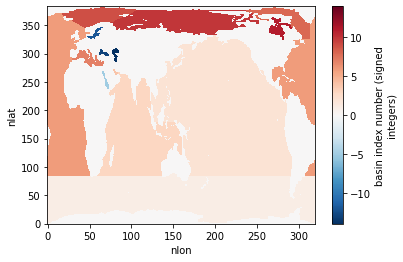

In [6]:
grid.REGION_MASK.plot()

In [7]:
lons = grid.TLONG
lats = grid.TLAT
years = ds.time.values
years

array([1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930,
       1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941,
       1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952,
       1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963,
       1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974,
       1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985,
       1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029,
       2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040,
       2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051,
       2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062,
       2063, 2064, 2065, 2066, 2067, 2068, 2069, 20

### mask out nans in ds

In [8]:
ds = ds.where(grid.REGION_MASK>0)

### extract 1920s

In [9]:
ds.time.isel(time=slice(0,10)).values

array([1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929])

In [10]:
ds_1920s = ds.isel(time=slice(0,10)).mean(dim='time')

### extract 1990s

In [11]:
ds.time.isel(time=slice(70,80)).values

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999])

In [12]:
ds_1990s = ds.isel(time=slice(70,80)).mean(dim='time')

### Extract 2090s

In [13]:
ds.time.isel(time=slice(-11,-1)).values

array([2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099])

In [14]:
ds_2090s = ds.isel(time=slice(-11,-1)).mean(dim='time')

In [15]:
ensemble_mean_1920s = ds_1920s.mean(dim='member_id')
ensemble_mean_1990s = ds_1990s.mean(dim='member_id')
ensemble_mean_2090s = ds_2090s.mean(dim='member_id')

### Read in masks

In [29]:
file = '/glade/work/kristenk/TTE_CESM-LE/masks_1990s.nc'
ds_masks = xr.open_dataset(file,decode_times=False)
ds_masks

<xarray.Dataset>
Dimensions:   (nlat: 384, nlon: 320)
Coordinates:
    TLAT      (nlat, nlon) float64 ...
    TLONG     (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    ACC_mask  (nlat, nlon) float64 ...
    SIZ_mask  (nlat, nlon) float64 ...

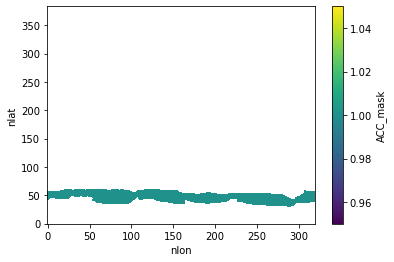

In [30]:
ds_masks.ACC_mask.plot()

In [31]:
diat_frac_change = ensemble_mean_2090s.diat_frac - ensemble_mean_1920s.diat_frac

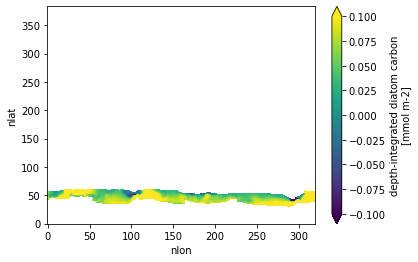

In [32]:
diat_frac_change.where(ds_masks.ACC_mask == 1).plot(vmin=-0.1,vmax=0.1)

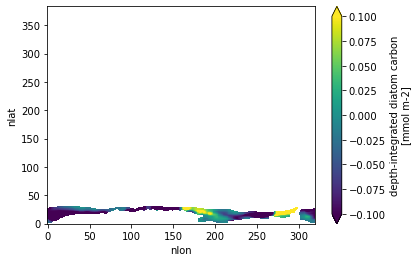

In [33]:
diat_frac_change.where(ds_masks.SIZ_mask == 1).plot(vmin=-0.1,vmax=0.1)

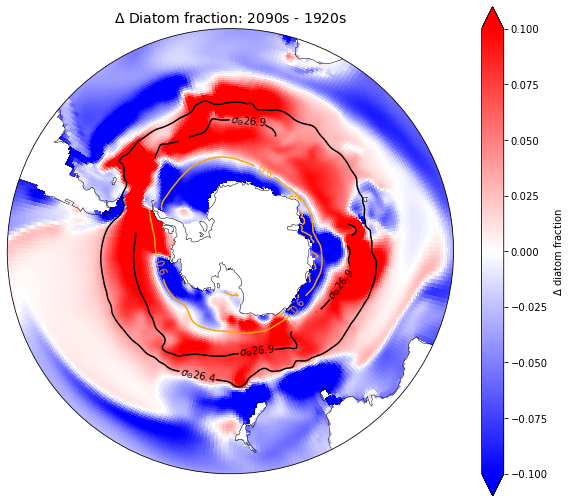

In [34]:
fig = plt.figure(figsize=(10,9))


#----------PLOT MEAN STATE---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, (ensemble_mean_2090s.diat_frac- ensemble_mean_1920s.diat_frac))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('${\Delta}$ Diatom fraction: 2090s - 1920s',fontsize=14)
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.1, vmax=0.1, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

############ masks ################################

### IFRAC
lon, lat, field = adjust_pop_grid(lons, lats, ensemble_mean_1990s.IFRAC)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pci=ax.contour(lon, lat, field,levels=[0.6],colors='orange',transform=ccrs.PlateCarree(),linewidth=6)

fmt = {}
strs = ['0.6']
for l, s in zip(pci.levels, strs):
    fmt[l] = s
ax.clabel(pci, pci.levels, inline=True, fmt=fmt, fontsize=10)

### SIGMA THETA
lon, lat, field = adjust_pop_grid(lons, lats, ensemble_mean_1990s.sigma_surf.where(ensemble_mean_1990s.IFRAC<0.01))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pci=ax.contour(lon, lat, field,levels=[26.5,26.9],colors='black',transform=ccrs.PlateCarree(),linewidth=2)

fmt = {}
strs = ['${\sigma}_{\Theta}$26.4','${\sigma}_{\Theta}$26.9']
for l, s in zip(pci.levels, strs):
    fmt[l] = s
ax.clabel(pci, pci.levels, inline=True, fmt=fmt, fontsize=10)


cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='${\Delta}$ diatom fraction')


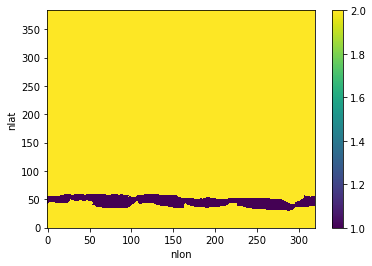

In [35]:
outside=np.full((384, 320), 2)

inside = ds_masks.ACC_mask.where(ds_masks.ACC_mask ==1)
inside = np.asarray(inside)


outside[~np.isnan(inside)] = inside[~np.isnan(inside)]

ACC=xr.DataArray(outside)
ACC=ACC.rename({'dim_0':'nlat'})
ACC=ACC.rename({'dim_1':'nlon'})
ACC.plot()

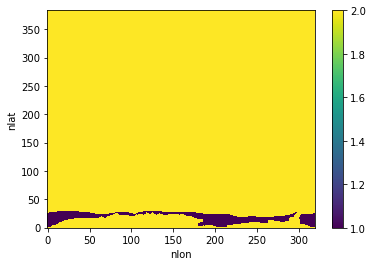

In [36]:
outside=np.full((384, 320), 2)

inside = ds_masks.SIZ_mask.where(ds_masks.SIZ_mask ==1)
inside = np.asarray(inside)


outside[~np.isnan(inside)] = inside[~np.isnan(inside)]

SIZ=xr.DataArray(outside)
SIZ=SIZ.rename({'dim_0':'nlat'})
SIZ=SIZ.rename({'dim_1':'nlon'})
SIZ.plot()

In [37]:
SIZ = SIZ.where(grid.REGION_MASK>0)

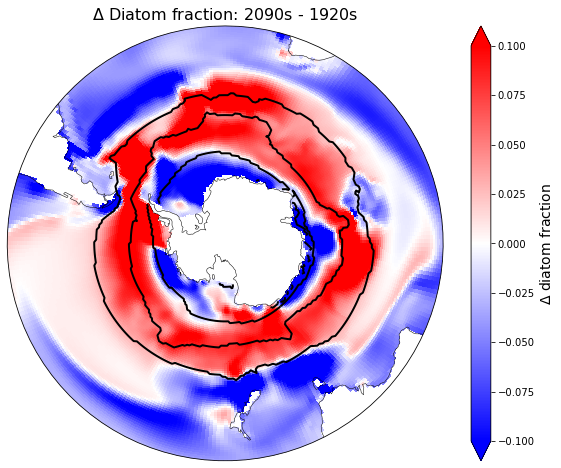

In [42]:
fig = plt.figure(figsize=(10,8))


#----------PLOT MEAN STATE---------------------------------------------------
lon, lat, field = adjust_pop_grid(lons, lats, (ensemble_mean_2090s.diat_frac- ensemble_mean_1920s.diat_frac))
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

ax = fig.add_subplot(1,1,1, projection=ccrs.SouthPolarStereo())
ax.set_title('${\Delta}$ Diatom fraction: 2090s - 1920s',fontsize=16)
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

#################### make it a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
#################### end circle

pc=ax.pcolormesh(lon, lat, 
                 field, vmin=-0.1, vmax=0.1, 
                 cmap='bwr',
                 transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

############ masks ################################

### IFRAC
lon, lat, field = adjust_pop_grid(lons, lats, SIZ)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

# fmt = {}
# strs = ['0.6']
# for l, s in zip(pci.levels, strs):
#     fmt[l] = s
# ax.clabel(pci, pci.levels, inline=True, fmt=fmt, fontsize=10)

### SIGMA THETA
lon, lat, field = adjust_pop_grid(lons, lats, ACC)
sh = lat[:, 0] < 0
lon = lon[sh, :]
lat = lat[sh, :]
field = field[sh, :]

pci=ax.contour(lon, lat, field,levels=[1],colors='black',transform=ccrs.PlateCarree(),linewidths=2)

# fmt = {}
# strs = ['${\sigma}_{\Theta}$26.4','${\sigma}_{\Theta}$26.9']
# for l, s in zip(pci.levels, strs):
#     fmt[l] = s
# ax.clabel(pci, pci.levels, inline=True, fmt=fmt, fontsize=10)


cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='${\Delta}$ diatom fraction')
cbar1.set_label(label='${\Delta}$ diatom fraction', fontsize=14)
fig.savefig('/glade/work/kristenk/figs/diatfracchange_withmasks.png', bbox_inches='tight', dpi=300, format='png');